# 13. Revisiting the multi-spore experiments

## Numerical experiments - Week 17/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

Having obtained more concrete estimates of the concentrations and diffusion coefficients of potential inhibitors, the quantitative effect of crowding on germination can be revisited in more detail. The computed reimaining inhibitor concentration in the spore under varying densities of regularly distributed spores can be related to statistical data from empirical experiments.

## Prerequisite libraries

In [1]:
using CurveFit
using PyPlot
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis

## 1. General assumptions

Previously, it was shown that the concentration threshold for germination inhibition in a single spore could lie anywhere between $10^{-10}$ and $10^{-6}\ \textrm{M}$. Matching these thresholds to effective permeation constants, diffusion simulations under increasing spore densities from $3\times 10^4$ to $3\times 10^9$ spores/mL are performed, recording the numerically estimated relaxation exponent and the inhibitor concentrations in the spores over the course of $t=12$ hours.

## 2. 3D spore grid

The most simple setup assumes a regular three-dimensional grid of spores or, equivalently, a triply periodic lattice. The different spore arrangements are visualised below.

Spore density: 3.0e-8 spores per micrometer^3
Populating volume of 1000000000 micrometers^3 with 3.0e-8 spores per um^3, 0.003107232505953859 spores per dimension
Spore spacing: 321.8297948685433 micrometers
Spore density: 5.334838230116768e-8 spores per micrometer^3
Populating volume of 1000000000 micrometers^3 with 5.334838230116768e-8 spores per um^3, 0.00376449812275292 spores per dimension
Spore spacing: 265.63965962844344 micrometers
Spore density: 9.486832980505138e-8 spores per micrometer^3
Populating volume of 1000000000 micrometers^3 with 9.486832980505138e-8 spores per um^3, 0.004560793596570562 spores per dimension
Spore spacing: 219.2600868304891 micrometers
Spore density: 1.6870239755710472e-7 spores per micrometer^3
Populating volume of 1000000000 micrometers^3 with 1.6870239755710472e-7 spores per um^3, 0.005525527587541392 spores per dimension
Spore spacing: 180.9781933321148 micrometers
Spore density: 3.0e-7 spores per micrometer^3
Populating volume of 1000000000 micr

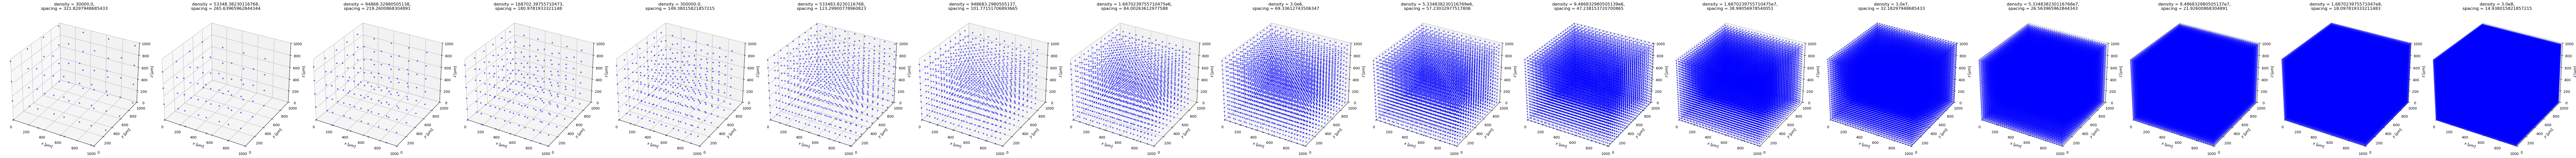

In [2]:
spore_densities = 3 * 10 .^ (4:0.25:8)

spore_arrangements = []
labels = []
spore_spacings = []
for spore_density in spore_densities
    spore_coords, spore_spacing = generate_spore_positions(spore_density, 1000, 1000, base_height=nothing)
    push!(spore_arrangements, spore_coords)
    push!(labels, "density = $spore_density,\nspacing = $spore_spacing")
    push!(spore_spacings, spore_spacing)
end

plot_spore_arrangements(1000, 1000, spore_arrangements, labels)

In [3]:
# Global parameters
D = cm2_to_um2(6.906e-6) # [um^2/s]
t_max = 14400 # s
c₀ = 1.5 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2 # microns
A, V = compute_spore_area_and_volume_from_dia(spore_diameter)
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes
n_save_frames = 100

# Variable parameters
cT_range = 10.0 .^ (-10:-6) # M
Ps_range = compute_permeation_constant.(cT_range, 0.0, c₀, t_max, A, V)

# Analytical solutions (round spore)
times_analytical = collect(LinRange(0, t_max, n_save_frames))
c_finals_an = zeros(length(spore_densities), length(Ps_range))
exponents_an = zeros(length(spore_densities), length(Ps_range))
for (i, ρₛ) in enumerate(spore_densities)
    for (j, Pₛ) in enumerate(Ps_range)
        c_analytical = concentration_at_spore_ambient_sources(times_analytical, c₀, 0.0, ρₛ, spore_rad, Pₛ)
        c_finals[i, j] = c_analytical[end]
        fit = exp_fit(times_analytical, c_analytical)
        exponents[i, j] = fit[2]
    end
end

# Analytical solutions (cubic spore)
A_cubic = 150
V_cubic = 125
c_finals_an_cubic = zeros(length(spore_densities), length(Ps_range))
exponents_an_cubic = zeros(length(spore_densities), length(Ps_range))
for (i, ρₛ) in enumerate(spore_densities)
    for (j, Pₛ) in enumerate(Ps_range)

        ρₛ = inverse_mL_to_cubic_um(ρₛ) # spores/mL to spores/um^3
        
        τ = V_cubic / (A_cubic * Pₛ)
        ϕ = ρₛ * V_cubic # volume fraction

        c_analytical = ϕ * c₀ .+ (1 - ϕ) .* c₀ .* exp.(-times_analytical ./ τ)

        c_finals_an_cubic[i, j] = c_analytical[end]
        fit = exp_fit(times_analytical, c_analytical)
        exponents_an_cubic[i, j] = fit[2]
    end
end

# Simulation parameters
# sim_params = Dict(
#     :sim_res => "medium",
#     :N => round.(Int, spore_spacings),
#     :dx => 5.0,
#     :dt => 0.005,
#     :t_max => t_max,
#     :D => D,
#     :Ps => Ps_range,
#     :c0 => c0_spore,
#     :n_save_frames => n_save_frames
# )

# run_simulations("250422_multi_spore", sim_params)

UndefVarError: UndefVarError: `c_finals` not defined

TEST IF SQUARE VS SPHERE SPORE MAKES A DIFFERENCE IN ANALYTICAL SOLUTION!

## 3. 2D spore grid in a 3D volume

# References